In [119]:
import cv2
import os

import matplotlib.pyplot as plt
from accelerate import Accelerator

import numpy as np
import torch
import torchvision.transforms as transforms
import torch.distributed as dist
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder, ImageNet

from utils.dataset import CustomDataset
from utils.image_tools import ImageTools

CUDA = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if CUDA else torch.FloatTensor
Device = "cuda" if CUDA else "cpu"
imgTools = ImageTools()

root = "../datasets/imagenet2012_processed_train"
batch_size = 1
num_workers = 0
image_size = 256


features_dir = os.path.join(root, f'imagenet{image_size}_features')
labels_dir = os.path.join(root, f'imagenet{image_size}_labels')
conditions_dir = os.path.join(root, f'imagenet{image_size}_conditions')

# Setup data:
dataset = CustomDataset(features_dir=features_dir, labels_dir=labels_dir, conditions_dir=conditions_dir)

loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )

def main():

    idx = 0
    x, y, c = None, None, None
    for x, y, c in loader:
        idx += 1
        if idx < 11:
            continue
        x = x.to(Device)
        y = y.to(Device)
        c = c.to(Device)
        
        if idx > 0:
            break
            
    print(idx, x.shape, y.shape, c.shape)
    return x, y, c

x, y, c = main()
        

11 torch.Size([1, 1, 3, 256, 256]) torch.Size([1, 1]) torch.Size([1, 256, 256])


In [120]:
from diffusers import AutoencoderKL
from copy import deepcopy
from models.DiT import DiT_models
from diffusion import create_diffusion

def requires_grad(model, flag=True):
    """
    Set requires_grad flag for all parameters in a model.
    """
    for p in model.parameters():
        p.requires_grad = flag
        
# Create model:
assert image_size % 8 == 0, "Image size must be divisible by 8 (for the VAE encoder)."
latent_size = image_size // 8
model_type = 'DiT-B/4'
model = DiT_models[model_type](
        input_size=latent_size,
        num_classes=1000,
        learn_sigma=False
    )
# # Note that parameter initialization is done within the DiT constructor
# model = model.to(Device)
# ema = deepcopy(model).to(Device)  # Create an EMA of the model for use after training
# requires_grad(ema, False)
diffusion = create_diffusion(timestep_respacing="")  # default: 1000 steps, linear noise schedule
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-ema").to(Device)
  # Setup optimizer (we used default Adam betas=(0.9, 0.999) and a constant learning rate of 1e-4 in our paper):
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([1, 4, 32, 32])

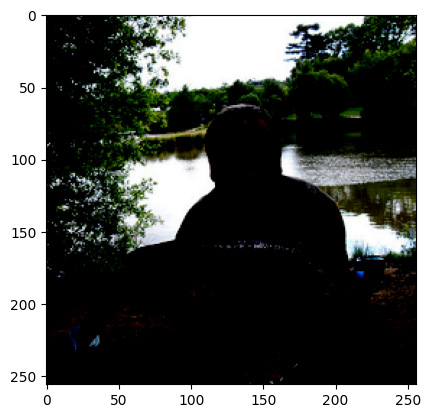

In [121]:
# from collections import OrderedDict
# from accelerate import Accelerator
# 
# accelerator = Accelerator()
# @torch.no_grad()
# def update_ema(ema_model, model, decay=0.9999):
#     """
#     Step the EMA model towards the current model.
#     """
#     ema_params = OrderedDict(ema_model.named_parameters())
#     model_params = OrderedDict(model.named_parameters())
# 
#     for name, param in model_params.items():
#         name = name.replace("module.", "")
#         # TODO: Consider applying only to params that require_grad to avoid small numerical changes of pos_embed
#         ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)

# 
# # Prepare models for training:
# update_ema(ema, model, decay=0)  # Ensure EMA is initialized with synced weights
# model.train()  # important! This enables embedding dropout for classifier-free guidance
# ema.eval()  # EMA model should always be in eval mode
# model, opt, loader = accelerator.prepare(model, opt, loader)

x = x.squeeze(dim=1)
plt.imshow(x[0].permute(1, 2, 0).cpu().detach().numpy())
with torch.no_grad():
            # Map input images to latent space + normalize latents:
    x = vae.encode(x).latent_dist.sample().mul_(0.18215)
y = y.squeeze(dim=1)
c = c.squeeze(dim=1)
t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=Device)
nx = model.forward(x, y, t)
nx.shape

In [122]:
# t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=Device)
# model_kwargs = dict(y=y)
# loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
# loss = loss_dict["loss"].mean()
# opt.zero_grad()
# accelerator.backward(loss)
# opt.step()
# update_ema(ema, model)

torch.Size([1, 4, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5142573..0.12551387].


torch.Size([1, 3, 256, 256])


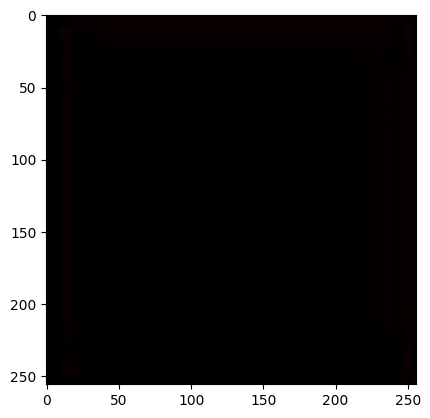

In [123]:

print(nx.shape)
sample = vae.decode(nx / 0.18215).sample
print(sample.shape)
# Save and display images:
plt.imshow(sample[0].permute(1, 2, 0).cpu().detach().numpy())
